In [1]:
'''
This file solves Aiyagiri with endogenous labour and taxes
ala Floden and Linde (2001)
'''

import numpy as np
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP
from numba import jit

In [15]:
class agent():


    def __init__(self,
                 r = 0.02,
                 w = 1.0,
                 cbeta = 0.96,
                 a_min = 1e-10,
                 a_max = 18,
                 a_size = 100,
                 P = [[0.9, 0.1],
                     [0.1, 0.9]],
                 z_vals = [0.1, 1.0]
                 ):

        self.r, self.w, self.cbeta, self.a_min, self.a_max, self.a_size = r, w, cbeta, a_min, a_max, a_size
        self.P = np.asarray(P)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.l_vals = np.linspace(1e-10, 1.0, a_size)
        self.n = self.z_size * self.a_size
        self.m = self.a_size * self.a_size

        # -- setting R and Q -- #

        # R
        self.R = np.empty((self.n, self.m))
        self.R.fill(-np.inf) # invalid values of utility have to be impossible to choose
        self.set_R()

        # Q
        self.Q = np.empty((self.n, self.m, self.n))
        self.set_Q()

    def set_R(self):
        build_R(self.R, self.z_vals, self.z_size, self.a_size, self.a_vals, self.l_vals, self.r, self.w)

    def set_Q(self):
        build_Q(self.Q, self.z_vals, self.z_size, self.a_vals, self.a_size, self.P)

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.set_R()

In [16]:

@jit
def build_R(R, z_vals, z_size, a_size, a_vals, l_vals, r, w):
    n = z_size * a_size
    for i in range(n):
        for j in range(a_size):
            for k in range(a_size):
                a_i = i // z_size
                z_i = i % z_size

                z = z_vals[z_i]
                a = a_vals[a_i]

                a_1 = a_vals[j]
                l = l_vals[k]

                c = w * l * z + (1 + r) * a - a_1

                if c > 0:
                    R[i, j*a_size + k] = np.log(c) - cpsi * (l ** (1.0 + ceta))/(1.0 + ceta)
@jit
def build_Q(Q, z_vals, z_size, a_val, a_size, P):
    n = a_size * z_size
    for i in range(n):
        z_i = i % z_size
        for z_i_1 in range(z_size):
            for a_i  in range(a_size):
                for l_i in range(a_size):
                    Q[i, a_i*a_size + l_i, a_i * z_size + z_i_1] = P[z_i, z_i_1]


@jit
def asset_pdf(s_pdf, a_size, z_size):

    a_pdf = np.zeros(a_size)

    for z_i in range(z_size):
        for a_i in range(a_size):
            a_pdf[a_i] += s_pdf[a_i * z_size + z_i]

    return a_pdf

@jit
def labour_pdf(s_pdf, a_size, z_size, z_vals):

    l_pdf = np.zeros(a_size)

    for z_i in range(z_size):
        for l_i in range(a_size):
            l_pdf[l_i] += z_vals[z_i] * s_pdf[l_i * z_size + z_i]

    return l_pdf

def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha))

def rd(K, N):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * calpha * (N / K)**(1 - calpha) - cdelta

def cap_lab_stock(am, r):
    """
    Map prices to the induced level of capital stock.

    Parameters:
    ----------

    am : Household
        An instance of an aiyagari_household.Household
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.cbeta)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_pdf(stationary_probs, am.a_size, am.z_size)
    # marginal distri for labour
    lab_probs = labour_pdf(stationary_probs, am.a_size, am.z_size, am.z_vals)
    # Return K
    return (np.sum(asset_probs * am.a_vals), np.sum(lab_probs * am.l_vals), w)


In [17]:
# Example prices
r = 0.03
w = 1
cpsi = 1
ceta = 2
A = 1
calpha = 0.33
cbeta = 0.96
cdelta = 0.05

# Create an instance of Household
am = agent(a_max=20, r=r, w=w)


# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.cbeta)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
l_vals = am.l_vals

a_pdf = asset_pdf(results.mc.stationary_distributions[0], a_size, z_size)

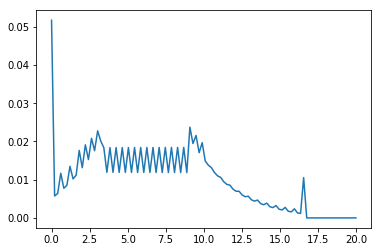

In [18]:
plt.plot(a_vals, a_pdf)

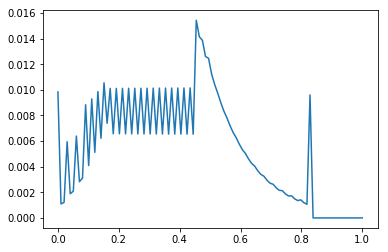

In [24]:
l_vals = am.l_vals
l_pdf = labour_pdf(results.mc.stationary_distributions[0], a_size, z_size, z_vals)
plt.plot(l_vals, l_pdf)

In [26]:
@jit
def solve_st_eq(r_min = 0.01, r_max = 0.1,
                n_vals = 100, tol = 1e-2):

    r_range = np.linspace(r_min, r_max, n_vals)
    #n_range = np.linspace(n_min, n_max, n_vals)

    iter = 1


    for r_i in r_range:

        # == Initialize agent == #
        am = agent(a_max=20)

        # == k supply == #
        k_s, l_s, w = cap_lab_stock(am, r_i)

        # == corresponding firm r using inverse capital demand func == #
        r_star = rd(k_s, l_s)

        # Check deviation
        error = np.absolute(r_i - r_star)

        #print(f'## == Iter {iter}')
        print('R guess: ', r_i)
        print('R star: ', r_star)
        print('Error: ', error)

        iter += 1
        if error < tol:
            r_eq = r_i
            k_eq = k_s
            w_eq = w
            l_eq = l_s
            return r_eq, k_eq, w_eq, l_eq
            break


In [27]:
# parameters
cpsi = 1
ceta = 2
A = 1
calpha = 0.33
cbeta = 0.96
cdelta = 0.05

r, k, w, l = solve_st_eq()
print(f'Equilibrium Interest Rate: {r}')
print(f'Equilibrium Capital Stock: {k}')
print(f'Equilibrium Wage: {w}')
print(f'Equilibrium Labour Stock: {l}')

R guess:  0.01
R star:  -0.01497798420229779
Error:  0.02497798420229779
R guess:  0.01090909090909091
R star:  -0.01500843082132279
Error:  0.0259175217304137
R guess:  0.011818181818181818
R star:  -0.015078279244212359
Error:  0.026896461062394177
R guess:  0.013636363636363637
R star:  -0.015233283369768653
Error:  0.02886964700613229
R guess:  0.015454545454545455
R star:  -0.015442351035891998
Error:  0.030896896490437455


MemoryError: 